# Investigate TreeCorr for Magnification
---

Resources:
- Example Python code from TreeCorr [wiki](https://github.com/rmjarvis/TreeCorr/wiki/Guide-to-using-TreeCorr-in-Python)
- TreeCorr [Documentation](http://rmjarvis.github.io/TreeCorr/html/index.html)
- TreeCorr [on GitHub](https://github.com/rmjarvis/TreeCorr/)
- DESC [notebook](https://github.com/DarkEnergyScienceCollaboration/2pt_validation/blob/master/ipynb/treecorr_example.ipynb)
- Dr. Phil Marshall's [notebook](https://github.com/drphilmarshall/StatisticalMethods/blob/03774abb4b92b30f381125e2d2e535e624f3e424/examples/SDSScatalog/CorrFunc.ipynb)
- Chris Davis' [notebook](https://github.com/cpadavis/cluster-z/blob/2f71a7c36bc9da8c369c1185ee5a7b39387cf4cd/notebooks/15_01_21__example_autocorrelation.ipynb)

Notes:
- `NGCorrelation` and `NKCorrelation` already have a `xi` attribute, but this is just the basic estimator $w = \frac{DD-RR}{RR}$
- both of above can compute Landy-Szalay *auto*-correlation estimator $w = \frac{DD-2DR+RR}{RR}$ using `calculateXi()`
- I don't think they have Landy-Szalay *cross*-correlation build in
- for full Landy-Szalay estimator need to use random catalogs that reflect survey geometry
- For `NKCorrelation` the second parameter has to be the data with `k`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import treecorr
from astropy.cosmology import Planck13 as cosmo
from astropy import units

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import catalog_munging as cm

In [3]:
import matplotlib
matplotlib.rcParams["axes.labelsize"] = 20
matplotlib.rcParams["axes.titlesize"] = 20
matplotlib.rcParams["legend.fontsize"] = 20

In [4]:
import astrolabels
al = astrolabels.AstroLabels()

## Landy-Szalay Estimator

In [5]:
def landyszalay_crosscorr(data1, data2, rand, weighted=True, config=None):
    """Return the LS estimation of the 2-point cross-correlation function."""
    
    # TO DO: add real checks on config
    if config is None:
        raise ValueError('must supply a config dict')

    d1r = treecorr.NNCorrelation(config)
    rr = treecorr.NNCorrelation(config)
    
    if weighted is False:
        d1d2 = treecorr.NNCorrelation(config)
        d2r = treecorr.NNCorrelation(config)
    else:
        d1d2 = treecorr.NKCorrelation(config)
        d2r = treecorr.NKCorrelation(config)
    
    d1d2.process(data1, data2)  # lens-source
    d2r.process(rand, data2)  # rand-source
    d1r.process(data1, rand)  # lens-rand
    rr.process(rand)

    d1d2_norm = d1d2.npairs/(data1.nobj*data2.nobj)
    d1r_norm = d1r.npairs/(data1.nobj*rand.nobj)
    d2r_norm = d2r.npairs/(data2.nobj*rand.nobj)
    rr_norm = 2.*rr.npairs/(rand.nobj*(rand.nobj-1.))  # count both permutations!
    
    corr = (d1d2_norm - d1r_norm - d2r_norm + rr_norm)/rr_norm   
    rbins = 10.**d1d2.logr

    return corr, rbins

In [6]:
#help(treecorr.NKCorrelation.process_pairwise)
#help(treecorr.NKCorrelation.process_cross)
#help(treecorr.NKCorrelation.process)

## Test correlation of random points

In [7]:
# need to understand correct use of config, esp. physical sep_units?
# From documentation: "Exactly three of nbins, bin_size, min_sep, max_sep are required"
rmax=5.
#config = {'nbins' : 10, 'min_sep' : 1., 'max_sep' : 100., 'sep_units' : 'arcmin'}
#config = {'nbins' : 10, 'min_sep' : 0.1, 'max_sep' : rmax*0.3, 'r_col' : 'Mpc'}
config = {'nbins' : 10, 'min_sep' : 0.1, 'max_sep' : rmax*0.3}

In [8]:
def get_fake_data(n1=200, n2=1000, nrand=1000, weighted=True):
    rand = treecorr.Catalog(x=np.random.rand(nrand)*rmax, 
                            y=np.random.rand(nrand)*rmax)
    data1 = treecorr.Catalog(x=np.random.rand(n1)*rmax, 
                             y=np.random.rand(n1)*rmax)
    if weighted is True:
        data2 = treecorr.Catalog(x=np.random.rand(n2)*rmax, 
                                 y=np.random.rand(n2)*rmax, 
                                 k=np.ones(n2))
    else:
        data2 = treecorr.Catalog(x=np.random.rand(n2)*rmax, 
                                 y=np.random.rand(n2)*rmax)
    return data1, data2, rand

In [9]:
data1, data2, rand = get_fake_data()

In [10]:
corr, r = landyszalay_crosscorr(data1, data2, rand, 
                                weighted=True, config=config)
corr

array([ 0.1841855 , -0.04411613, -0.05871405, -0.01309027,  0.02739403,
       -0.00748443, -0.0234903 ,  0.01305022, -0.00347991, -0.00322431])

In [11]:
ntimes = 100
correlations = []
for i in range(ntimes):
    data1, data2, rand = get_fake_data()
    c, r = landyszalay_crosscorr(data1, data2, rand, 
                                 weighted=True, config=config)
    correlations.append(c)

correlations = np.array(correlations)

corr = correlations.mean(axis=0)
stddev = correlations.std(axis=0)
stderr = stddev/np.sqrt(ntimes)

#print(corr)
#print(stderr)

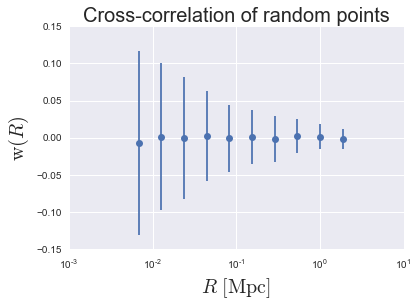

In [12]:
plt.errorbar(r, corr, yerr=stddev, fmt='o')
plt.xscale('log')
plt.title('Cross-correlation of random points')
plt.xlabel(al.r_mpc)
plt.ylabel('$\mathrm{w}(R)$')
plt.show()

## Source data for W1

In [13]:
udrop_path = '/Users/jesford/astrophysics/data/cfhtls/LBGS/WIDE/udrops/'
udata = cm.load_all_pointings('W1', path=udrop_path)

In [14]:
udf = udata['W1m0m0']
udf.head()

,x[0],x[1],RA,DEC,MAG_TOT_g,MAG_TOT_r,MAG_AUTO,MAG_TOT_z,am1,z,dmag_g,dmag_r,dmag_i,dmag_z
0,11605.118,1332.244,34.442415,-7.473653,24.6383,24.0592,24.2164,24.9847,1.549960,3.1,-0.292730,-0.559807,-0.117846,0.831743
1,2098.610,1342.422,34.937767,-7.472915,25.0159,24.7888,24.4280,24.6757,0.595831,3.1,0.084869,0.169792,0.093754,0.522743
2,3143.255,1340.603,34.883336,-7.473059,23.9368,23.4518,22.4929,21.6854,3.011820,3.1,-0.994230,-1.167210,-1.841340,-2.467560
3,18167.999,1361.317,34.100447,-7.471975,24.2006,23.9439,24.0301,23.7864,1.768430,3.1,-0.730431,-0.675108,-0.304146,-0.366556
4,1734.356,1365.712,34.956745,-7.471693,25.5145,25.4068,25.3995,24.7231,0.163619,3.1,0.583469,0.787792,1.065250,0.570145


## Lens data for W1

In [15]:
# all W1 clusters
cluster_path_combined = '/Users/jesford/astrophysics/data/cfhtls/clusters/'
cdf_allW1 = cm.make_dataframe(cluster_path_combined+'Clusters_W1.dat')
print(cdf_allW1.shape)
cdf_allW1.head()

(10745, 5)


,RA,DEC,z,sig,n200
0,34.8023,-7.01005,0.3,4.435,10
1,34.9425,-7.38996,0.5,4.545,21
2,34.8651,-6.69449,0.5,3.858,6
3,34.6224,-7.32768,0.5,3.619,8
4,34.4551,-7.18236,0.5,3.622,12


In [16]:
cluster_path = '/Users/jesford/astrophysics/data/cfhtls/clusters/WIDE/'
cdata = cm.load_all_pointings('W1', path=cluster_path)

In [17]:
cdf = cdata['W1m0m0']
cdf.head()

,RA,DEC,z,sig,x[0],x[1],m200,r200,n200
0,34.8023,-7.01005,0.3,4.435,4692.14,10303.70,13.0429,0.437770,9.99850
1,34.9425,-7.38996,0.5,4.545,2006.82,2948.05,13.0566,0.410869,20.99830
2,34.8651,-6.69449,0.5,3.858,3481.96,16410.50,12.9714,0.377355,5.99858
3,34.6224,-7.32768,0.5,3.619,8149.35,4157.43,12.9418,0.366348,7.99867
4,34.4551,-7.18236,0.5,3.622,11361.90,6970.45,12.9421,0.366484,11.99870


## Random (masked) data for W1

In [18]:
rand_path = '/Users/jesford/astrophysics/data/cfhtls/randoms/'
rdata = cm.load_all_pointings('W1', path=rand_path)

In [19]:
rdf = rdata['W1m0m0']
rdf.head()

,x[0],x[1]
0,16422.00,3083.39
1,17604.00,4229.14
2,16617.30,14149.30
3,3871.44,18711.50
4,12293.40,4357.30


## Correlate in a redshift bin

In [20]:
config = {'nbins' : 10, 'min_sep' : 0.1, 'max_sep' : 5.0}

redshift = 0.2

pointings_list = list(cdata.keys())
correlations = []

for pointing in pointings_list:
    cdf = cdata[pointing]
    udf = udata[pointing]
    rdf = rdata[pointing]
    
    lenses = cm.get_catalog(cdf, lens=True, z_lens=redshift)
    sources = cm.get_catalog(udf, weights=['am1'], z_lens=redshift)
    randoms = cm.get_catalog(rdf, z_lens=redshift)

    c, r = landyszalay_crosscorr(lenses, sources, randoms, weighted=True, 
                                 config=config)
    correlations.append(c)
    
correlations = np.array(correlations)

corr = correlations.mean(axis=0)
stddev = correlations.std(axis=0)
stderr = stddev/np.sqrt(len(pointings_list))

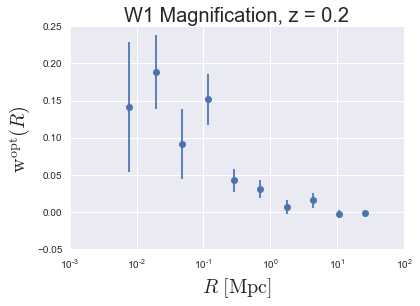

In [21]:
plt.errorbar(r, corr, yerr=stderr, fmt='o')
plt.xscale('log')
plt.title('W1 Magnification, z = '+str(redshift))
plt.xlabel(al.r_mpc)
plt.ylabel('$\mathrm{w}^\mathrm{opt}(R)$')
plt.show()

## TO DO: 
- check LBGs are appropriately masked
- magnitude & other cuts on LBGs
- loop over all fields W1-4
- loop over all redshifts
- calculate error bars (or covariance matrix) from all pointings